In [3]:
import math
import numpy as np
import filterpy as fpy
from numpy.random import randn
from scipy.linalg import solve
import pandas as pd


### DATA CLEANING AND EXTRACTION

In [90]:
# File_data = np.loadtxt(r"C:\Users\flame\Documents\CS5340\ewap_dataset_full\ewap_dataset\seq_eth\obsmat.txt") 

File_data = np.loadtxt(r"C:\Users\flame\OneDrive\Documents\CS5340\ewap_dataset_full\ewap_dataset\seq_eth\obsmat.txt") 
print(File_data.shape) 
#(8908, 8)
#[frame_number pedestrian_ID pos_x pos_z pos_y v_x v_z v_y ]
#367 predestrians in video

(8908, 8)


## Obtaining list of pedestrians' IDs with at least 20 data rows


In [91]:
row_list = []
for i in range(1,368):
    row_list.append((np.count_nonzero(File_data[:,1]==i),i))

row_list.sort(reverse = True)
MoreThan20Data_Pedestrian_list = []
for i in row_list:
    if i[0]>=20:
        MoreThan20Data_Pedestrian_list.append(i[1])
        
# MoreThan20Data_Pedestrian_list = [353]
# MoreThan20Data_df = MoreThan20Data_df.rename(columns = {"Frame_ID":"Time (s)"})


### Getting DataFrame version of Raw Data

In [92]:
raw_df = pd.DataFrame(File_data)
raw_df = raw_df.drop([3, 6], axis=1)
raw_df = raw_df.rename(columns={0: "Frame_ID", 1: "Pedestrian_ID", 2:"X_Pos",4:"Y_Pos",5:"X_Vel",7:"Y_Vel"})

## Ground Truth Data (Take from EWAP Dataset)

In [93]:
groundtruth_dataset =[]

# for i in MoreThan20Data_Pedestrian_list:
#     groundtruth_dataset = raw_df[raw_df["Pedestrian_ID"]==MoreThan20Data_Pedestrian_list[i]]
MoreThan20Data_df = raw_df[raw_df['Pedestrian_ID'].isin(MoreThan20Data_Pedestrian_list)].reset_index(drop=True)
MoreThan20Data_df["Frame_ID"] = MoreThan20Data_df["Frame_ID"]/25
MoreThan20Data_df = MoreThan20Data_df.rename(columns = {"Frame_ID":"Time (s)"})


### Noisy Data (pos_sensor_std = 0.3 , vel_sensor_std = 0.45)

In [94]:
# define a function to apply to the norm dist
def norm_dist(mean,std):
    return np.random.normal(mean,std)

pos_sensor_std =0.3
vel_sensor_std =0.45

NoisyMoreThan20Data_df = MoreThan20Data_df.copy(deep=True)

# apply the function to the salary column using apply()
NoisyMoreThan20Data_df['X_Pos'] = MoreThan20Data_df['X_Pos'].apply(norm_dist,std=pos_sensor_std)
NoisyMoreThan20Data_df['Y_Pos'] = MoreThan20Data_df['Y_Pos'].apply(norm_dist,std=pos_sensor_std)
NoisyMoreThan20Data_df['X_Vel'] = MoreThan20Data_df['X_Vel'].apply(norm_dist,std=vel_sensor_std)
NoisyMoreThan20Data_df['Y_Vel'] = MoreThan20Data_df['Y_Vel'].apply(norm_dist,std=vel_sensor_std)


### Generation of the KF data (BaseLine Model) with FUNCTION (Using Pedestrian's 1st Noisy Data Point as initial position)

### pos_sensor_std =0.3
### vel_sensor_std =0.45


In [95]:
# # #ASSUME Uniform distribution

# #Max and min position x
# max_x = np.ceil(max(File_data[:,2]))
# min_x = np.floor(min(File_data[:,2]))
# mean_x = (max_x+min_x)/2

# var_x = ((max_x-min_x)**2)/12


# #Max and min position y
# max_y = np.ceil(max(File_data[:,4]))
# min_y = np.floor(min(File_data[:,4]))
# mean_y = (max_y+min_y)/2

# var_y = ((max_y-min_y)**2)/12


# #Average person's walking speed (3ph = 1.34112 m/s) and a normal distribution
# mean_vx = 1.34112
# vx_sigma = 1.34112/3
# vx_variance = vx_sigma**2

# mean_vy = 1.34112
# vy_sigma = 1.34112/3
# vy_variance = vy_sigma**2

#### NOTE: USING MARCUS's pos_process_std = 0.2  , vel_process_std = 0.1 settings

In [171]:
vardict_NoisyMoreThan20Data ={}
for i in MoreThan20Data_Pedestrian_list:
    vardict_NoisyMoreThan20Data[i] = {}
    ref = NoisyMoreThan20Data_df[NoisyMoreThan20Data_df["Pedestrian_ID"]==i].copy(deep=True).reset_index(drop=True).var()
    vardict_NoisyMoreThan20Data[i]['X_Pos'] = ref['X_Pos']
    vardict_NoisyMoreThan20Data[i]['Y_Pos'] = ref['Y_Pos']
    vardict_NoisyMoreThan20Data[i]['X_Vel'] = ref['X_Vel']
    vardict_NoisyMoreThan20Data[i]['Y_Vel'] = ref['Y_Vel']
    

In [172]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

d_t = 0.24 #Assume 1st Time Step (6 frames with 25 FPS) is 0.24 seconds

# Transition Matrix / Function
State_Transition_Matrix = np.array([[1, d_t, 0, 0],
                                    [0, 1, 0, 0],
                                    [0, 0, 1, d_t],
                                    [0, 0, 0, 1]])

# Measurement / Emission Funxction
Measurement_Function = np.array([[1, 0, 0, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, 1]])
# Initial State Mean and Covariance
# Initial_State = np.array([mean_x, mean_vx, mean_y, mean_vy])
# Covariance_Matrix = np.diag([var_x, vx_variance ,var_y,vy_variance])

#Environment Noise (Friction Air resistane) NOTE!!!!!!!!!!
pos_process_std = 0.2 
vel_process_std = 0.1
Process_Noise = np.diag([pos_process_std**2, vel_process_std**2, 
                         pos_process_std**2, vel_process_std**2])

#Sensor Noise
Measurement_Noise = np.array([[pos_sensor_std**2, 0,0,0],[0, vel_sensor_std**2,0,0], [0,0, pos_sensor_std**2,0],[0, 0,0,vel_sensor_std**2]])


def KF_model_evaluator_V2(State_Transition_Matrix,Measurement_Function,Process_Noise,vardict_NoisyMoreThan20Data,Measurement_Noise):
    total_noisy_observations =[]
    total_KF_predict = []
    total_groundtruth_list = []
    kf_cov_list=[]
    
    for i in MoreThan20Data_Pedestrian_list:

        Covariance_Matrix = np.diag([vardict_NoisyMoreThan20Data[i]['X_Pos'],
                                     vardict_NoisyMoreThan20Data[i]['X_Vel'],
                                     vardict_NoisyMoreThan20Data[i]['Y_Pos'],
                                     vardict_NoisyMoreThan20Data[i]['Y_Vel']])
        
        noisy_ref_pedestrian_df = NoisyMoreThan20Data_df[NoisyMoreThan20Data_df["Pedestrian_ID"]==i].copy(deep=True).reset_index(drop=True)
        ref_pedestrian_df = MoreThan20Data_df[MoreThan20Data_df["Pedestrian_ID"]==i].copy(deep=True).reset_index(drop=True)
        # print("Initial_VELOCITY_State[0] :",Initial_VELOCITY_State[0])
        noisy_ref_pedestrian_df = noisy_ref_pedestrian_df.sort_values(by = ['Time (s)']).reset_index(drop = True)
        ref_pedestrian_df = ref_pedestrian_df.sort_values(by = ['Time (s)']).reset_index(drop = True)                                                              
        Initial_State = np.array([noisy_ref_pedestrian_df.loc[0,"X_Pos"] ,noisy_ref_pedestrian_df.loc[0,"X_Vel"],noisy_ref_pedestrian_df.loc[0,"Y_Pos"] ,noisy_ref_pedestrian_df.loc[0,"Y_Vel"]])
    
        
        # Initialize the Kalman Filter
        kf = KalmanFilter(dim_x=4, dim_z=4)
        d_t = 0.24
        # State Transition Matrix (We design)
        kf.F = State_Transition_Matrix
        # Measurement Function (We design)
        kf.H = Measurement_Function
        # Initial State (We design)
        kf.x = Initial_State  # [x, vx, y, vy]
        # Covariance Matrix (We design)
        kf.P =Covariance_Matrix
        # Process Noise (We fine tune)
        kf.Q = Process_Noise
        # Measurement Noise (We fix as constant / fine tune )?
        kf.R = Measurement_Noise
        # Observations
        noisy_observations = []

        #Get noisy observations
        for i in range(len(noisy_ref_pedestrian_df)):
            ref = [noisy_ref_pedestrian_df.loc[i,"X_Pos"],noisy_ref_pedestrian_df.loc[i,"X_Vel"],noisy_ref_pedestrian_df.loc[i,"Y_Pos"],noisy_ref_pedestrian_df.loc[i,"Y_Vel"]]
            noisy_observations.append(ref)
        total_noisy_observations.extend(noisy_observations)
        noisy_observations = np.array(noisy_observations)
        
        #Get ground truth observations
        groundtruth_observations = []
        for i in range(len(ref_pedestrian_df)):
            ref = [ref_pedestrian_df.loc[i,"X_Pos"],ref_pedestrian_df.loc[i,"X_Vel"],ref_pedestrian_df.loc[i,"Y_Pos"],ref_pedestrian_df.loc[i,"Y_Vel"]]
            groundtruth_observations.append(ref)
        total_groundtruth_list.extend(groundtruth_observations)
        
        # Update loop
        #Get KF Predicted observations
        xs, cov,kf_predict=[], [], []
        for obs_i in range(len(noisy_observations)):
            if obs_i == 0:
                ref = [kf.x[0],kf.x[1],kf.x[2],kf.x[3]]
                kf_predict.append(ref)
                xs.append(kf.x)
                cov.append((i,obs_i))
                continue
                
            if obs_i != 0:
                d_t = noisy_ref_pedestrian_df.loc[i,"Time (s)"]-noisy_ref_pedestrian_df.loc[i-1,"Time (s)"]
            else:
                d_t = 0.24 #ASSUME 1st Time Step is 0.24 seconds
            kf.F = np.array([[1, d_t, 0, 0], 
                         [0, 1, 0, 0], 
                         [0, 0, 1, d_t], 
                         [0, 0, 0, 1]])
            kf.H = Measurement_Function
            kf.predict()
            kf.update(noisy_observations[obs_i])
            ref = [kf.x[0],kf.x[1],kf.x[2],kf.x[3]]
            kf_predict.append(ref)
            cov.append((kf.P,i))
        total_KF_predict.extend(kf_predict)
        kf_cov_list.extend(cov)
        
        # xs, cov = np.array(xs), np.array(cov)
        
    total_noisy_observations = np.array(total_noisy_observations)
    total_KF_predict = np.array(total_KF_predict)
    total_groundtruth_list = np.array(total_groundtruth_list)
    return total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list

### Evaluation of the BaseLine Model V2 (Using Pedestrian's 1st Noisy Data Point as initial position)

In [173]:
total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",round(np.mean(ed_pos_clean_noisy),5) )
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(ed_pos_clean_kf),5) )

ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",round(np.mean(ed_vel_clean_noisy),5) )
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(ed_vel_clean_kf),5) )

baseline_sum = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
noisy_sum =  np.mean(ed_pos_clean_noisy) + np.mean(ed_vel_clean_noisy)
print("----------------------------------------------------------------")
print("SUM of Euclidean Position + Velocity for Kalman Filter", round(baseline_sum,5))
print("SUM of Euclidean Position + Velocity for Noisy Data", round(noisy_sum,5))

----------------------------------------------------------------
Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.29794
----------------------------------------------------------------
Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.30729
----------------------------------------------------------------
SUM of Euclidean Position + Velocity for Kalman Filter 0.60523
SUM of Euclidean Position + Velocity for Noisy Data 0.9375


## Modelling BASELINE process noise

#### We first get the Difference between the predicted time step velocity/position and the actual time step velocity/position (Not using KF model but just using the kinematic eqs)

#### Error_X_Pos / Error_Y_Pos = Actual X/Y Pos - (Prev X/Y Pos + Prev X/Y velocity * Time Delta)
#### Error_X_Vel / Error_Y_Vel = Actual X/Y Velocity - Prev X/Y Velocity


In [174]:
OPN_noisy_pedestrian_df = NoisyMoreThan20Data_df.copy(deep=True).reset_index(drop=True)

extra_cols = ["Error_X_Pos",
              "Error_Y_Pos",
              "Error_X_Vel",
              "Error_Y_Vel",
             ]

end_index = len(OPN_noisy_pedestrian_df.columns)

for i in extra_cols:
    OPN_noisy_pedestrian_df.insert(end_index, i,0)
    end_index+=1

filled_total_noisy_ped_df = pd.DataFrame(columns=list(OPN_noisy_pedestrian_df.columns))

for i in list(OPN_noisy_pedestrian_df.columns):
    filled_total_noisy_ped_df[i]= filled_total_noisy_ped_df[i].astype(float)

for i in list(OPN_noisy_pedestrian_df.columns):
    OPN_noisy_pedestrian_df[i]= OPN_noisy_pedestrian_df[i].astype(float)

In [175]:
for i in MoreThan20Data_Pedestrian_list:
    
    noisy_ped_df = OPN_noisy_pedestrian_df[OPN_noisy_pedestrian_df["Pedestrian_ID"]==i].copy(deep=True).reset_index(drop=True)
    noisy_ped_df = noisy_ped_df.sort_values(by=['Time (s)'])

    for j in range(len(noisy_ped_df)):
        if j ==0:
            continue

        noisy_ped_df.loc[j,"Error_X_Pos"] = noisy_ped_df.loc[j,"X_Pos"] - (noisy_ped_df.loc[j-1,"X_Pos"]+(noisy_ped_df.loc[j-1,"X_Vel"]*(noisy_ped_df.loc[j,"Time (s)"]-noisy_ped_df.loc[j-1,"Time (s)"])))
        noisy_ped_df.loc[j,"Error_Y_Pos"] = noisy_ped_df.loc[j,"Y_Pos"] - (noisy_ped_df.loc[j-1,"Y_Pos"]+(noisy_ped_df.loc[j-1,"Y_Vel"]*(noisy_ped_df.loc[j,"Time (s)"]-noisy_ped_df.loc[j-1,"Time (s)"])))
        noisy_ped_df.loc[j,"Error_X_Vel"] = noisy_ped_df.loc[j,"X_Vel"] - noisy_ped_df.loc[j-1,"X_Vel"]
        noisy_ped_df.loc[j,"Error_Y_Vel"] = noisy_ped_df.loc[j,"Y_Vel"] - noisy_ped_df.loc[j-1,"Y_Vel"]

    filled_total_noisy_ped_df = pd.concat([filled_total_noisy_ped_df, noisy_ped_df], ignore_index=True, axis=0)


In [176]:
filled_total_noisy_ped_df

,Time (s),Pedestrian_ID,X_Pos,Y_Pos,X_Vel,Y_Vel,Error_X_Pos,Error_Y_Pos,Error_X_Vel,Error_Y_Vel
0,324.60,171.0,-0.865611,8.897479,-0.047307,0.137823,0.000000,0.000000,0.000000,0.000000
1,324.84,171.0,-0.611197,8.376013,-0.069406,-0.412108,0.265767,-0.554544,-0.022099,-0.549931
2,325.08,171.0,-1.094691,7.910638,0.071562,-0.757623,-0.466836,-0.366468,0.140968,-0.345515
3,325.32,171.0,-1.026734,8.542432,-1.124868,-0.191429,0.050782,0.813624,-1.196430,0.566194
4,325.56,171.0,-0.637461,8.290462,-0.555210,0.038507,0.659241,-0.206028,0.569658,0.229936
...,...,...,...,...,...,...,...,...,...,...
7758,90.96,45.0,2.344922,3.167692,-1.585358,-0.252223,-0.433205,-0.515179,-0.770689,0.399372
7759,91.20,45.0,1.722969,3.750579,-1.318388,-0.098225,-0.241467,0.643420,0.266970,0.153998
7760,91.44,45.0,1.075394,3.830068,-1.095426,-0.651590,-0.331162,0.103063,0.222962,-0.553366
7761,91.68,45.0,-0.037570,3.800533,-0.528642,0.422559,-0.850062,0.126846,0.566784,1.074149


### Now we get the Process Noise Standard Deviation given Mean is 0

In [177]:
# Getting X_Pos_std given MEAN is 0
sum =0
for i in filled_total_noisy_ped_df["Error_X_Pos"]:
    sum+=((i)**2)
X_Pos_std = math.sqrt(sum/(filled_total_noisy_ped_df.shape[0]-1))

# Getting Y_Pos_std given MEAN is 0
sum =0
for i in filled_total_noisy_ped_df["Error_Y_Pos"]:
    sum+=((i)**2)
Y_Pos_std = math.sqrt(sum/(filled_total_noisy_ped_df.shape[0]-1)) 

# Getting X_Vel_std given MEAN is 0
sum =0
for i in filled_total_noisy_ped_df["Error_X_Vel"]:
    sum+=((i)**2)
X_Vel_std = math.sqrt(sum/(filled_total_noisy_ped_df.shape[0]-1)) 

# Getting Y_Vel_std given MEAN is 0
sum =0
for i in filled_total_noisy_ped_df["Error_Y_Vel"]:
    sum+=((i)**2)
Y_Vel_std = math.sqrt(sum/(filled_total_noisy_ped_df.shape[0]-1)) 

print("X_Pos_std :",round(X_Pos_std,5))
print("Y_Pos_std :",round(Y_Pos_std,5))
print("X_Vel_std :",round(X_Vel_std,5))
print("Y_Vel_std :",round(Y_Vel_std,5))

X_Pos_std : 0.48456
Y_Pos_std : 0.4418
X_Vel_std : 0.64437
Y_Vel_std : 0.63931


### Testing BaseLine Process Noise Kalman Filter

In [178]:
print("X_Pos_std :",round(X_Pos_std,5))
print("Y_Pos_std :",round(Y_Pos_std,5))
print("X_Vel_std :",round(X_Vel_std,5))
print("Y_Vel_std :",round(Y_Vel_std,5))

X_Pos_std : 0.48456
Y_Pos_std : 0.4418
X_Vel_std : 0.64437
Y_Vel_std : 0.63931


In [179]:
BASELINE_X_Pos_std  = X_Pos_std 
BASELINE_Y_Pos_std  = Y_Pos_std  
BASELINE_X_Vel_std  = X_Vel_std 
BASELINE_Y_Vel_std  = Y_Vel_std 

In [180]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

d_t = 0.24 #ASSUME 1st Time Step (6 frames with 25 fps) is 0.24 seconds

# Transition Matrix / Function
State_Transition_Matrix = np.array([[1, d_t, 0, 0],
                                    [0, 1, 0, 0],
                                    [0, 0, 1, d_t],
                                    [0, 0, 0, 1]])

# Measurement / Emission Funxction
Measurement_Function = np.array([[1, 0, 0, 0],
                                 [0, 1, 0, 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, 1]])

# # Initial Covariance
# Covariance_Matrix = np.diag([var_x, vx_variance ,var_y,vy_variance])

Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

#Sensor Noise
Measurement_Noise = np.array([[pos_sensor_std**2, 0,0,0],[0, vel_sensor_std**2,0,0], [0,0, pos_sensor_std**2,0],[0, 0,0,vel_sensor_std**2]])


In [181]:
total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",round(np.mean(ed_pos_clean_noisy),5))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(ed_pos_clean_kf),5))

ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",round(np.mean(ed_vel_clean_noisy),5))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(ed_vel_clean_kf),5))

baseline_sum = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
noisy_sum =  np.mean(ed_pos_clean_noisy) + np.mean(ed_vel_clean_noisy)
print("----------------------------------------------------------------")
print("SUM of Euclidean Position + Velocity for Kalman Filter", round(baseline_sum,5))
print("SUM of Euclidean Position + Velocity for Noisy Data", round(noisy_sum,5))

----------------------------------------------------------------
Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.30641
----------------------------------------------------------------
Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.43631
----------------------------------------------------------------
SUM of Euclidean Position + Velocity for Kalman Filter 0.74272
SUM of Euclidean Position + Velocity for Noisy Data 0.9375


### Sensitivity Analysis

### Reduce each Process Noise STD by 10% and obtain the Change in SUM of Euclidean Position + Velocity Error

In [182]:
Process_Noise_X_Pos = np.diag([(BASELINE_X_Pos_std*0.9) **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std **2])

Process_Noise_Y_Pos = np.diag([(BASELINE_X_Pos_std) **2, BASELINE_X_Vel_std **2,
                         (BASELINE_Y_Pos_std*0.9) **2, BASELINE_Y_Vel_std **2])

Process_Noise_X_Vel = np.diag([(BASELINE_X_Pos_std) **2, (BASELINE_X_Vel_std*0.9) **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std **2])

Process_Noise_Y_Vel = np.diag([(BASELINE_X_Pos_std) **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, (BASELINE_Y_Vel_std*0.9) **2])                                                                                           

In [183]:
Process_noise_list = [Process_Noise_X_Pos,Process_Noise_Y_Pos,Process_Noise_X_Vel,Process_Noise_Y_Vel]

Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

# ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
# print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",np.mean(ed_pos_clean_noisy) )
# print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",np.mean(ed_pos_clean_kf) )

# ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
# print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",np.mean(ed_vel_clean_noisy) )
# print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",np.mean(ed_vel_clean_kf) )
original_ED_mean_sum = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)

sum_mean_ED_list = []

for i in Process_noise_list:
    total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                         Measurement_Function,
                                                                                                         i,
                                                                                                         vardict_NoisyMoreThan20Data,
                                                                                                         Measurement_Noise)

#     ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
    ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
    
#     ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
    
    ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
    sum_mean_ED = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
    sum_mean_ED_list.append(sum_mean_ED)


print("Process_Noise_X_Pos DELTA:",round(sum_mean_ED_list[0]-original_ED_mean_sum,7))
print("Process_Noise_Y_Pos DELTA:",round(sum_mean_ED_list[1]-original_ED_mean_sum,7))
print("Process_Noise_X_Vel DELTA:",round(sum_mean_ED_list[2]-original_ED_mean_sum,7))
print("Process_Noise_Y_Vel DELTA:",round(sum_mean_ED_list[3]-original_ED_mean_sum,7))

Process_Noise_X_Pos DELTA: -0.0020221
Process_Noise_Y_Pos DELTA: -0.0041223
Process_Noise_X_Vel DELTA: -0.0067218
Process_Noise_Y_Vel DELTA: -0.0068528


### Increase each Process Noise STD by 10%

In [184]:
Process_Noise_X_Pos = np.diag([(BASELINE_X_Pos_std*1.1) **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std **2])

Process_Noise_Y_Pos = np.diag([(BASELINE_X_Pos_std) **2, BASELINE_X_Vel_std **2,
                         (BASELINE_Y_Pos_std*1.1) **2, BASELINE_Y_Vel_std **2])

Process_Noise_X_Vel = np.diag([(BASELINE_X_Pos_std) **2, (BASELINE_X_Vel_std*1.1) **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std **2])

Process_Noise_Y_Vel = np.diag([(BASELINE_X_Pos_std) **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, (BASELINE_Y_Vel_std*1.1) **2])       

In [185]:
Process_noise_list = [Process_Noise_X_Pos,Process_Noise_Y_Pos,Process_Noise_X_Vel,Process_Noise_Y_Vel]

Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

 
# ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
# print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",np.mean(ed_pos_clean_noisy) )

# print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",np.mean(ed_pos_clean_kf) )

# ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))

# print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",np.mean(ed_vel_clean_noisy) )

# print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",np.mean(ed_vel_clean_kf) )
original_ED_mean_sum = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)

sum_mean_ED_list = []

for i in Process_noise_list:
    total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                         Measurement_Function,
                                                                                                         i,
                                                                                                         vardict_NoisyMoreThan20Data,
                                                                                                         Measurement_Noise)

#     ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
    ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
#     ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
    ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
    sum_mean_ED = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
    sum_mean_ED_list.append(sum_mean_ED)
 

print("Process_Noise_X_Pos DELTA:",round(sum_mean_ED_list[0]-original_ED_mean_sum,7))
print("Process_Noise_Y_Pos DELTA:",round(sum_mean_ED_list[1]-original_ED_mean_sum,7))
print("Process_Noise_X_Vel DELTA:",round(sum_mean_ED_list[2]-original_ED_mean_sum,7))
print("Process_Noise_Y_Vel DELTA:",round(sum_mean_ED_list[3]-original_ED_mean_sum,7))

Process_Noise_X_Pos DELTA: 0.0022099
Process_Noise_Y_Pos DELTA: 0.0037385
Process_Noise_X_Vel DELTA: 0.0060065
Process_Noise_Y_Vel DELTA: 0.0061323


### Observations: We want the Process Noise DELTA to decrease as that indicates that the Euclidean Distance Sum Error decreased, and we do
### StepWise decrease change with the following process (In order of highest Process Noise Delta to lowest):
### Process_Noise_Y_Vel > Process_Noise_X_Vel > Process_Noise_Y_Pos > Process_Noise_X_Pos (Reduce all by 5% at a time)

## StepWise Optimization

In [186]:
### BaseLine Process noise

Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, (BASELINE_Y_Vel_std)  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(ed_pos_clean_kf),7))

ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(ed_vel_clean_kf),7))

current_sum_mean_ED =  np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
current_sum_mean_ED

Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.3064129
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.4363068


0.7427196875404927

In [187]:
output = 0
loop_checker = True
prev_Process_Noise = 0

Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(ed_pos_clean_kf),7))

ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(ed_vel_clean_kf),7))

current_sum_mean_ED = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
current_Process_Noise = Process_Noise

loop_dict ={
    0:True,
    1:True,
    2:True,
    3:True
}

X_Pos_std =BASELINE_X_Pos_std
X_Vel_std =BASELINE_X_Vel_std
Y_Pos_std =BASELINE_Y_Pos_std
Y_Vel_std =BASELINE_Y_Vel_std

Iteration_results =[]

while loop_checker==True:
    for i in range(4):
        
        prev_Process_Noise = current_Process_Noise
        prev_sum_mean_ED = current_sum_mean_ED
        # print("prev_sum_mean_ED :",prev_sum_mean_ED)

        
        if i ==0 and loop_dict[0]==True:
            Y_Vel_std = Y_Vel_std*0.95
            
        elif i ==1 and loop_dict[1]==True:
            X_Vel_std = X_Vel_std*0.95
            
        elif i ==2 and loop_dict[2]==True:
            Y_Pos_std = Y_Pos_std*0.95
            
        elif i ==3 and loop_dict[3]==True:
            X_Pos_std = X_Pos_std*0.95
            
        current_Process_Noise = np.diag([(X_Pos_std) **2, X_Vel_std **2,
                     (Y_Pos_std) **2, Y_Vel_std **2])
        
        total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     current_Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)
        ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
        ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
        current_sum_mean_ED = np.mean(ed_pos_clean_kf) + np.mean(ed_vel_clean_kf)
        Iteration_results.append(current_sum_mean_ED)
        # print("TEST_current_sum_mean_ED:",current_sum_mean_ED )
        if (current_sum_mean_ED-prev_sum_mean_ED) >0:
            print("i :",i)
            loop_dict[i]=False

        if loop_dict[0]==False and loop_dict[1]==False and loop_dict[2]==False and loop_dict[3]==False:     
            output = prev_Process_Noise
            print("Output :", output)
            print("current_sum_mean_ED (Next Worse Iteration):",current_sum_mean_ED )
            print("SUM of Euclidean Position  for Kalman Filter :",prev_sum_mean_ED )
            loop_checker = False
            break


    

Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.3064129
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.4363068
i : 3
i : 2
i : 0
i : 1
Output : [[0.11450353 0.         0.         0.        ]
 [0.         0.01033637 0.         0.        ]
 [0.         0.         0.01223285 0.        ]
 [0.         0.         0.         0.01017467]]
current_sum_mean_ED (Next Worse Iteration): 0.5596951805408785
SUM of Euclidean Position  for Kalman Filter : 0.5596721057313367


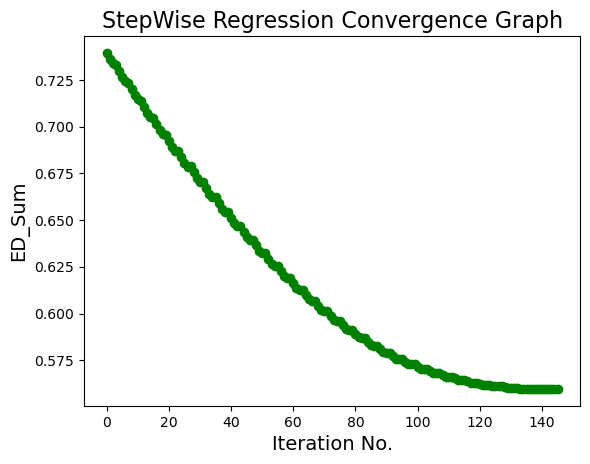

In [188]:
iter= list(range(0,len(Iteration_results)))
plt.plot(iter, Iteration_results, linestyle='--', marker='o', color='g')
plt.title ('StepWise Regression Convergence Graph',fontsize=16)
plt.xlabel ('Iteration No.',fontsize=14)
plt.ylabel ('ED_Sum',fontsize=14)

plt.show()

In [189]:
len(Iteration_results)

146

#### Optimized Results

In [190]:
print("Output Diagonal:", output.diagonal())

OPTIMIZED_X_Pos_std = math.sqrt(output.diagonal()[0])
OPTIMIZED_X_Vel_std = math.sqrt(output.diagonal()[1])
OPTIMIZED_Y_Pos_std = math.sqrt(output.diagonal()[2])
OPTIMIZED_Y_Vel_std = math.sqrt(output.diagonal()[3])

print("OPTIMIZED_X_Pos_std", round(OPTIMIZED_X_Pos_std,6))
print("OPTIMIZED_X_Vel_std", round(OPTIMIZED_X_Vel_std,6))
print("OPTIMIZED_Y_Pos_std", round(OPTIMIZED_Y_Pos_std,6))
print("OPTIMIZED_Y_Vel_std", round(OPTIMIZED_Y_Vel_std,6))

Output Diagonal: [0.11450353 0.01033637 0.01223285 0.01017467]
OPTIMIZED_X_Pos_std 0.338384
OPTIMIZED_X_Vel_std 0.101668
OPTIMIZED_Y_Pos_std 0.110602
OPTIMIZED_Y_Vel_std 0.10087


In [191]:
## Marcus dummy Values
# SUM of Euclidean Position  for Kalman Filter 0.49957

## BaseLine values
# SUM of Euclidean Position for Kalman Filter 0.69784

## Optimized Values
# SUM of Euclidean Position  for Kalman Filter 0.4717805712446064

#### Comparison between BaseLine and Optimized KF Model

In [192]:
import matplotlib.pyplot as plt
import random


def plot_stepwise_graph(cumulative_rmse_noisy, cumulative_rmse_kf, cumulative_rmse_kf_baseline, label_noisy, label_kf, label_baseline,title, ylabel):
    """
    Plots the cumulative RMSE for noisy data and Kalman Filter predictions.

    :param cumulative_rmse_noisy: Numpy array of cumulative RMSE values for noisy data.
    :param cumulative_rmse_kf: Numpy array of cumulative RMSE values for Kalman Filter predictions.
    :param label_noisy: Label for the noisy data plot.
    :param label_kf: Label for the Kalman Filter data plot.
    :param title: Title of the plot.
    :param ylabel: Y-axis label of the plot.
    """
    steps = np.arange(1, len(cumulative_rmse_noisy) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, cumulative_rmse_noisy, label=label_noisy, color='red', marker='o')
    plt.plot(steps, cumulative_rmse_kf, label=label_kf, color='green', marker='x')
    plt.plot(steps, cumulative_rmse_kf_baseline, label=label_baseline, color='blue', marker='s')
    
    plt.title(title,fontsize = 16)
    plt.xlabel('Timestep',fontsize = 16)
    plt.ylabel(ylabel,fontsize = 16)
    plt.legend()
    plt.grid(True)
    plt.show()

#### For BaseLine Model

In [193]:
BASELINE_X_Pos_std

0.4845562461358055

In [194]:
Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
BASELINE_ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",round(np.mean(ed_pos_clean_noisy),5))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(ed_pos_clean_kf),5))

ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
BASELINE_ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",round(np.mean(ed_vel_clean_noisy),5))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(ed_vel_clean_kf),5))

BASELINE_baseline_sum = np.mean(BASELINE_ed_pos_clean_kf) + np.mean(BASELINE_ed_vel_clean_kf)
noisy_sum =  np.mean(ed_pos_clean_noisy) + np.mean(ed_vel_clean_noisy)
print("----------------------------------------------------------------")
print("SUM of Euclidean Position for Kalman Filter", round(BASELINE_baseline_sum,5))
print("SUM of Euclidean Position for Noisy Data", round(noisy_sum,5))

----------------------------------------------------------------
Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.26974
----------------------------------------------------------------
Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.28995
----------------------------------------------------------------
SUM of Euclidean Position for Kalman Filter 0.74272
SUM of Euclidean Position for Noisy Data 0.9375


In [195]:
Process_Noise = np.diag([BASELINE_X_Pos_std **2, BASELINE_X_Vel_std **2,
                         BASELINE_Y_Pos_std **2, BASELINE_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
BASELINE_ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",round(np.mean(ed_pos_clean_noisy),5))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(BASELINE_ed_pos_clean_kf),5))

ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
BASELINE_ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",round(np.mean(ed_vel_clean_noisy),5))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(BASELINE_ed_vel_clean_kf),5))

BASELINE_baseline_sum = np.mean(BASELINE_ed_pos_clean_kf) + np.mean(BASELINE_ed_vel_clean_kf)
noisy_sum =  np.mean(ed_pos_clean_noisy) + np.mean(ed_vel_clean_noisy)
print("----------------------------------------------------------------")
print("SUM of Euclidean Position for Kalman Filter", round(BASELINE_baseline_sum,5))
print("SUM of Euclidean Position for Noisy Data", round(noisy_sum,5))

----------------------------------------------------------------
Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.30641
----------------------------------------------------------------
Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.43631
----------------------------------------------------------------
SUM of Euclidean Position for Kalman Filter 0.74272
SUM of Euclidean Position for Noisy Data 0.9375


In [196]:
ed_squared_pos_clean_noisy = ed_pos_clean_noisy**2
BASELINE_ed_squared_pos_clean_kf = BASELINE_ed_pos_clean_kf**2
ed_squared_vel_clean_noisy = ed_vel_clean_noisy**2
BASELINE_ed_squared_vel_clean_kf = BASELINE_ed_vel_clean_kf**2

# Cumulative RMSE - Position
cumulative_rmse_pos_noisy = np.sqrt(np.cumsum(ed_squared_pos_clean_noisy) / np.arange(1, len(ed_squared_pos_clean_noisy) + 1))
baseline_cumulative_rmse_pos_kf = np.sqrt(np.cumsum(BASELINE_ed_squared_pos_clean_kf) / np.arange(1, len(BASELINE_ed_squared_pos_clean_kf) + 1))
# Cumulative RMSE - Velocity
cumulative_rmse_vel_noisy = np.sqrt(np.cumsum(ed_squared_vel_clean_noisy) / np.arange(1, len(ed_squared_vel_clean_noisy) + 1))
baseline_cumulative_rmse_vel_kf = np.sqrt(np.cumsum(BASELINE_ed_squared_vel_clean_kf) / np.arange(1, len(BASELINE_ed_squared_vel_clean_kf) + 1))

In [197]:
print("cumulative_rmse_pos_noisy :", cumulative_rmse_pos_noisy[-1])
print("cumulative_rmse_pos_kf :", baseline_cumulative_rmse_pos_kf[-1])
print("cumulative_rmse_vel_noisy :", cumulative_rmse_vel_noisy[-1])
print("cumulative_rmse_vel_kf :", baseline_cumulative_rmse_vel_kf[-1])

cumulative_rmse_pos_noisy : 0.4235756040478512
cumulative_rmse_pos_kf : 0.3463199344914642
cumulative_rmse_vel_noisy : 0.6339193149355098
cumulative_rmse_vel_kf : 0.49149503718529214


In [198]:
Process_Noise = np.diag([OPTIMIZED_X_Pos_std **2, OPTIMIZED_X_Vel_std **2,
                         OPTIMIZED_Y_Pos_std **2, OPTIMIZED_Y_Vel_std  **2])

total_groundtruth_list,total_noisy_observations,total_KF_predict,kf_cov_list = KF_model_evaluator_V2(State_Transition_Matrix,
                                                                                                     Measurement_Function,
                                                                                                     Process_Noise,
                                                                                                     vardict_NoisyMoreThan20Data,
                                                                                                     Measurement_Noise)

ed_pos_clean_noisy = np.sqrt(((total_groundtruth_list[:,0]-total_noisy_observations[:,0])**2)+((total_groundtruth_list[:,2]-total_noisy_observations[:,2])**2))
OPTIMIZED_ed_pos_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,0]-total_KF_predict[:,0])**2)+((total_groundtruth_list[:,2]-total_KF_predict[:,2])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Distance Error for Noisy Data X/Y Positions: ",round(np.mean(ed_pos_clean_noisy),5))
print("Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions: ",round(np.mean(OPTIMIZED_ed_pos_clean_kf),5))

ed_vel_clean_noisy = np.sqrt(((total_groundtruth_list[:,1]-total_noisy_observations[:,1])**2)+((total_groundtruth_list[:,3]-total_noisy_observations[:,3])**2))
OPTIMIZED_ed_vel_clean_kf = np.flip(np.sqrt(((total_groundtruth_list[:,1]-total_KF_predict[:,1])**2)+((total_groundtruth_list[:,3]-total_KF_predict[:,3])**2)))
print("----------------------------------------------------------------")
print("Mean Euclidean Velocity Error for Noisy Data X/Y Velocities: ",round(np.mean(ed_vel_clean_noisy),5))
print("Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities: ",round(np.mean(OPTIMIZED_ed_vel_clean_kf),5))

OPTIMIZED_baseline_sum = np.mean(OPTIMIZED_ed_pos_clean_kf) + np.mean(OPTIMIZED_ed_vel_clean_kf)
noisy_sum =  np.mean(ed_pos_clean_noisy) + np.mean(ed_vel_clean_noisy)
print("----------------------------------------------------------------")
print("SUM of Euclidean Position for Kalman Filter", round(OPTIMIZED_baseline_sum,5))
print("SUM of Euclidean Position for Noisy Data", round(noisy_sum,5))

----------------------------------------------------------------
Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.26977
----------------------------------------------------------------
Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.2899
----------------------------------------------------------------
SUM of Euclidean Position for Kalman Filter 0.55967
SUM of Euclidean Position for Noisy Data 0.9375


In [199]:
ed_squared_pos_clean_noisy = ed_pos_clean_noisy**2
OPTIMIZED_ed_squared_pos_clean_kf = OPTIMIZED_ed_pos_clean_kf**2
ed_squared_vel_clean_noisy = ed_vel_clean_noisy**2
OPTIMIZED_ed_squared_vel_clean_kf = OPTIMIZED_ed_vel_clean_kf**2

# Cumulative RMSE - Position
cumulative_rmse_pos_noisy = np.sqrt(np.cumsum(ed_squared_pos_clean_noisy) / np.arange(1, len(ed_squared_pos_clean_noisy) + 1))
OPTIMIZED_cumulative_rmse_pos_kf = np.sqrt(np.cumsum(OPTIMIZED_ed_squared_pos_clean_kf) / np.arange(1, len(OPTIMIZED_ed_squared_pos_clean_kf) + 1))
# Cumulative RMSE - Velocity
cumulative_rmse_vel_noisy = np.sqrt(np.cumsum(ed_squared_vel_clean_noisy) / np.arange(1, len(ed_squared_vel_clean_noisy) + 1))
OPTIMIZED_cumulative_rmse_vel_kf = np.sqrt(np.cumsum(OPTIMIZED_ed_squared_vel_clean_kf) / np.arange(1, len(OPTIMIZED_ed_squared_vel_clean_kf) + 1))

In [200]:
print("cumulative_rmse_pos_noisy :", cumulative_rmse_pos_noisy[-1])
print("cumulative_rmse_pos_kf :", OPTIMIZED_cumulative_rmse_pos_kf[-1])
print("cumulative_rmse_vel_noisy :", cumulative_rmse_vel_noisy[-1])
print("cumulative_rmse_vel_kf :", OPTIMIZED_cumulative_rmse_vel_kf[-1])


cumulative_rmse_pos_noisy : 0.4235756040478512
cumulative_rmse_pos_kf : 0.3073660979492646
cumulative_rmse_vel_noisy : 0.6339193149355098
cumulative_rmse_vel_kf : 0.34024667566361577


In [202]:
# Mean Euclidean Distance Error for Noisy Data X/Y Positions:  0.3755
# Mean Euclidean Distance Error for Kalman Filter Data X/Y Positions:  0.26986
# ----------------------------------------------------------------
# Mean Euclidean Velocity Error for Noisy Data X/Y Velocities:  0.562
# Mean Euclidean Velocity Error for Kalman Filter Data X/Y Velocities:  0.29014
# ----------------------------------------------------------------
# SUM of Euclidean Position for Kalman Filter 0.55999
# SUM of Euclidean Position for Noisy Data 0.9375

# cumulative_rmse_pos_noisy : 0.4235756040478512
# cumulative_rmse_pos_kf : 0.30742651731248966
# cumulative_rmse_vel_noisy : 0.6339193149355098
# cumulative_rmse_vel_kf : 0.34064567985398575

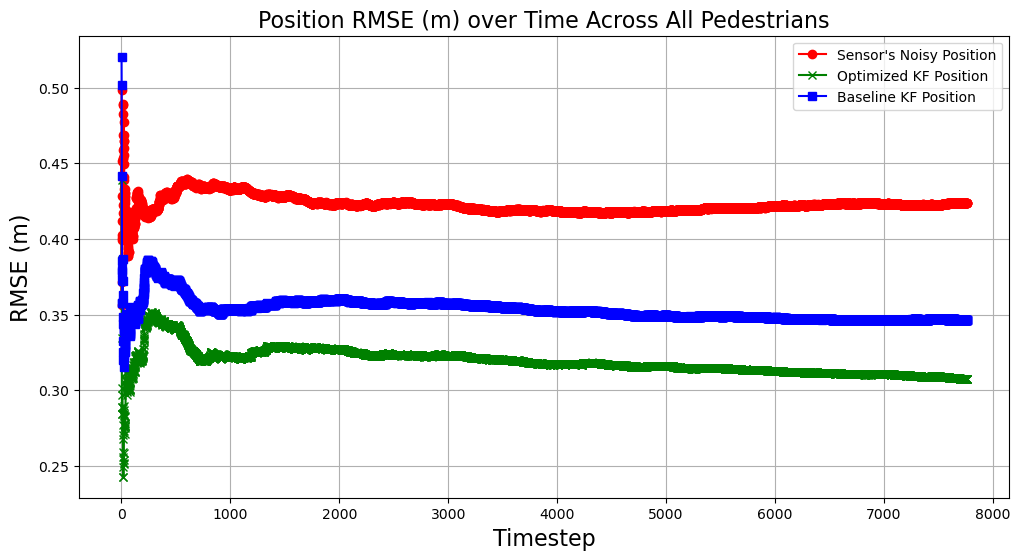

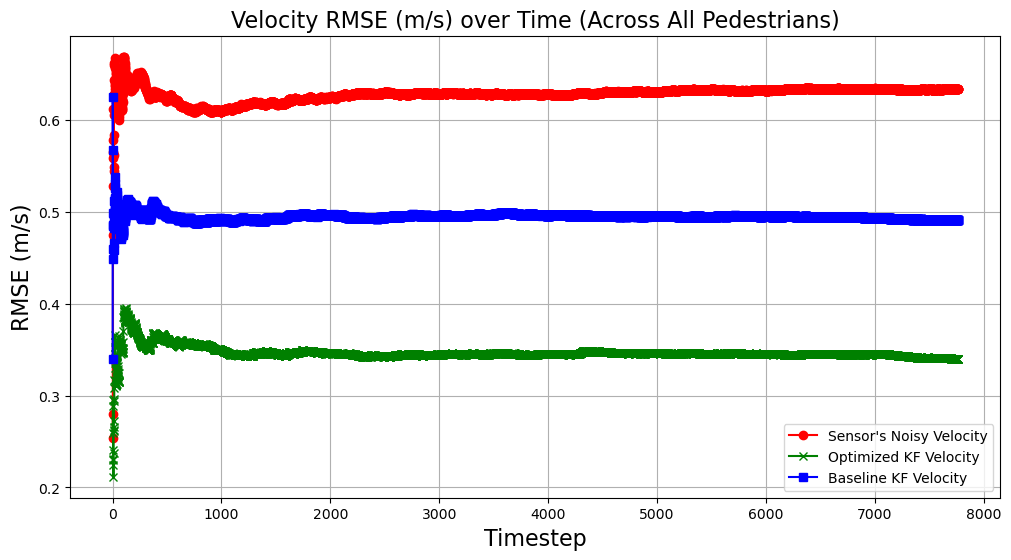

In [203]:
plot_stepwise_graph(cumulative_rmse_pos_noisy, OPTIMIZED_cumulative_rmse_pos_kf,baseline_cumulative_rmse_pos_kf ,'Sensor\'s Noisy Position', 'Optimized KF Position','Baseline KF Position', 'Position RMSE (m) over Time Across All Pedestrians', 'RMSE (m)')
plot_stepwise_graph(cumulative_rmse_vel_noisy, OPTIMIZED_cumulative_rmse_vel_kf,baseline_cumulative_rmse_vel_kf ,'Sensor\'s Noisy Velocity', 'Optimized KF Velocity','Baseline KF Velocity', 'Velocity RMSE (m/s) over Time (Across All Pedestrians)', 'RMSE (m/s)')

In [205]:
print("Optimized KF Model Position ED RMSE :", round(OPTIMIZED_cumulative_rmse_pos_kf[-1],3))
print("Optimized KF Model Velocity ED RMSE :", round(OPTIMIZED_cumulative_rmse_vel_kf[-1],3))

print("Baseline KF Model Position ED RMSE :", round(baseline_cumulative_rmse_pos_kf[-1],3))
print("Baseline KF Model Velocity ED RMSE :", round(baseline_cumulative_rmse_vel_kf[-1],3))

print("Noisy Sensor Position ED RMSE :", round(cumulative_rmse_pos_noisy[-1],3))
print("Noisy Sensor Velocity ED RMSE :", round(cumulative_rmse_vel_noisy[-1],3))

Optimized KF Model Position ED RMSE : 0.307
Optimized KF Model Velocity ED RMSE : 0.34
Baseline KF Model Position ED RMSE : 0.346
Baseline KF Model Velocity ED RMSE : 0.491
Noisy Sensor Position ED RMSE : 0.424
Noisy Sensor Velocity ED RMSE : 0.634
